# Fungi Image Classification

### Problem Statement
- In this project, we are trying to classify fungi images into 5 fungi types H1, H2, H3, H5 and H6
- We are using Transfer learning using ResNet152

### Dataset
- Source : https://archive.ics.uci.edu/static/public/773/defungi.zip
- Total instances : 9114
- Number of classes : 5 
- Classes :
  - H1 - Tortuous septate hyaline hyphae (TSH)
  - H2 - Beaded arthroconidial septate hyaline hyphae (BASH)
  - H3 - Groups or mosaics of arthroconidia (GMA)
  - H5 - Septate hyaline hyphae with chlamydioconidia (SHC) 
  - H6 - Broad brown hyphae (BBH)

### Importing required packages 

In [1]:
!pip install torchsummary

In [2]:
import urllib.request
from zipfile import ZipFile 
import os 
from pathlib import Path
from shutil import copy
import pandas as pd 
import torch, torchvision 
from sklearn.model_selection import train_test_split 
from torchvision import transforms 
import os 
from torch.utils.data import DataLoader 
from torch.optim import lr_scheduler
from torchvision import models 
from torchsummary import summary
from tqdm import tqdm
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

### Setting device to 'cuda' if cuda is available

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Downloading Data

In [3]:
dataset_url = "https://archive.ics.uci.edu/static/public/773/defungi.zip"
zip_filename = 'data.zip'

if not os.path.exists('data.zip'):
    urllib.request.urlretrieve(dataset_url, zip_filename)

### Extracting data into a directory 'raw_data'

In [4]:
directory_name = './raw_data'
if not os.path.exists(directory_name):
    os.mkdir(directory_name)

In [6]:
with ZipFile('data.zip', 'r') as archive:
    archive.extractall(path = 'raw_data')

### Creating pandas DataFrame which contains details about the image path and image label 

In [7]:
path = 'raw_data'
df = pd.DataFrame(columns=['image_path', 'image_label'])
for directory, sub_directories, files in os.walk(path):
    for file in files:
        image_label = file[:2]
        image_path = os.path.join(directory, file)
        new_row = {
            'image_path'   : image_path,
            'image_label'  : image_label,
        } 
        df.loc[len(df)] = new_row

### Creating a new directory 'data'
- It contains 3 folders, 'train', 'test', 'valid' 
- Each folder contains 5 folders, 'H1', 'H2', 'H3', 'H5', 'H6' (classes)

In [9]:
if not os.path.exists('data'):
    os.mkdir('data')
sub_directories = ['train', 'test', 'valid']
classes = ['H1', 'H2', 'H3', 'H5', 'H6']

for sub_directory in sub_directories:
    Path(os.path.join('data', sub_directory)).mkdir(parents = True, exist_ok=True)
    
for sub_directory in sub_directories:
    for class_label in classes:
        Path(os.path.join('data', sub_directory, class_label)).mkdir(parents = True, exist_ok=True)

In [10]:
df.head()

,image_path,image_label
0,raw_data/H6/H6_28a_1.jpg,H6
1,raw_data/H6/H6_59a_10.jpg,H6
2,raw_data/H6/H6_72a_19.jpg,H6
3,raw_data/H6/H6_57b_6.jpg,H6
4,raw_data/H6/H6_39a_2.jpg,H6


### We split our data into train, valid, test set in ratio of 70:15:15

In [12]:
path_train_valid, path_test, label_train_valid, label_test = train_test_split(df['image_path'], df['image_label'], stratify=df['image_label'], random_state=42, shuffle = True, test_size=0.15)
path_train, path_valid, label_train, label_valid = train_test_split(path_train_valid, label_train_valid, stratify=label_train_valid, random_state=42, shuffle = True, test_size=0.176)

### Populating 'data' directory

In [13]:
for path, label in zip(path_test, label_test):
    source_path = Path(path)
    target_path = Path(os.path.join('data', 'test', label))
    copy(source_path, target_path)
    
for path, label in zip(path_train, label_train):
    source_path = Path(path)
    target_path = Path(os.path.join('data', 'train', label))
    copy(source_path, target_path)

for path, label in zip(path_valid, label_valid):
    source_path = Path(path)
    target_path = Path(os.path.join('data', 'valid', label))
    copy(source_path, target_path)

### Distribution of classes for train, valid and test set

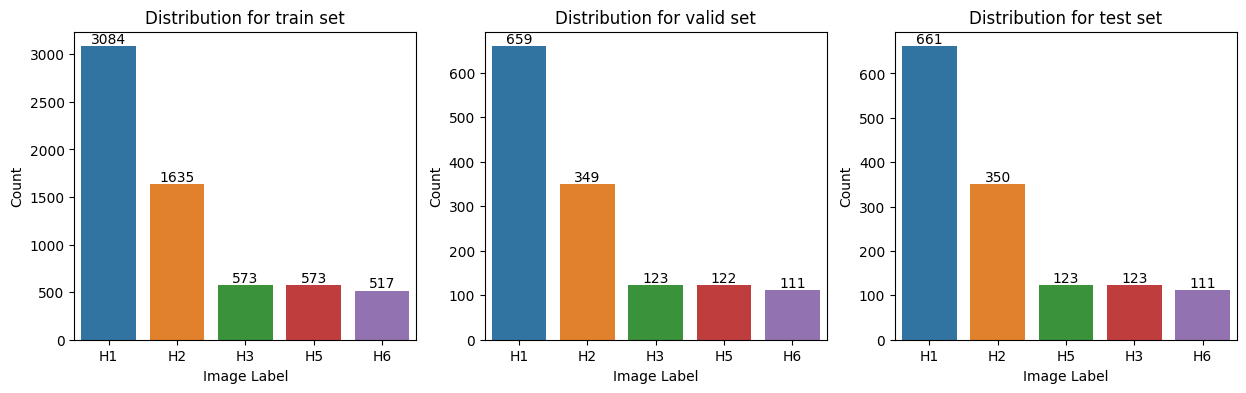

In [29]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))
bar_df = label_train.value_counts().reset_index()
bar_df.columns = ['Image Label', 'Count']
sns.barplot(bar_df, x = 'Image Label', y = 'Count', ax = axes[0])
axes[0].bar_label(axes[0].containers[0])
axes[0].set_title('Distribution for train set')

bar_df = label_valid.value_counts().reset_index()
bar_df.columns = ['Image Label', 'Count']
sns.barplot(bar_df, x = 'Image Label', y = 'Count', ax = axes[1])
axes[1].bar_label(axes[1].containers[0])
axes[1].set_title('Distribution for valid set')

bar_df = label_test.value_counts().reset_index()
bar_df.columns = ['Image Label', 'Count']
sns.barplot(bar_df, x = 'Image Label', y = 'Count', ax = axes[2])
axes[2].bar_label(axes[2].containers[0])
axes[2].set_title('Distribution for test set')

for i in range(3):
    axes[i].set_xlabel('Image Label')
    axes[i].set_ylabel('Count')

### Image Transform for train, valid and test set

In [13]:
img_transforms = {
    'train': torchvision.transforms.Compose([
        transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ]),
    
    'valid': torchvision.transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ]),
        
    'test': torchvision.transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])
}

### Creating train and valid dataset 

In [14]:
train_dataset_path = './data/train'
valid_dataset_path = './data/valid'

In [15]:
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform=img_transforms['train'])
valid_dataset = torchvision.datasets.ImageFolder(root = valid_dataset_path, transform=img_transforms['valid'])

#### Training Dataset

In [16]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 6382
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

#### Validation Dataset

In [17]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 1364
    Root location: ./data/valid
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### Creating DataLoader from train and valid dataset

In [18]:
batch_size = 16
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [19]:
print(f'Classes with their index = {train_dataset.class_to_idx}')
print(f'Number of classes = {len(train_dataset.class_to_idx)}')

Classes with their index = {'H1': 0, 'H2': 1, 'H3': 2, 'H5': 3, 'H6': 4}
Number of classes = 5


In [20]:
idx_to_class = {value:key for (key, value) in train_dataset.class_to_idx.items()}
print(f'Index to Class = {idx_to_class}')

Index to Class = {0: 'H1', 1: 'H2', 2: 'H3', 3: 'H5', 4: 'H6'}


In [21]:
train_size = len(train_dataset)
valid_size = len(valid_dataset)
print(f'Size of training set = {train_size}')
print(f'Size of validation set = {valid_size}')

Size of training set = 6382
Size of validation set = 1364


### Displaying fungi images with their class labels

In [22]:
indices = []
while(len(indices)!=5):
    indices = []
    images, labels = next(iter(train_data_loader))
    for j in range(5):
        for i in range(len(labels)):
            if labels[i] == j :
                indices.append(i)
                break       

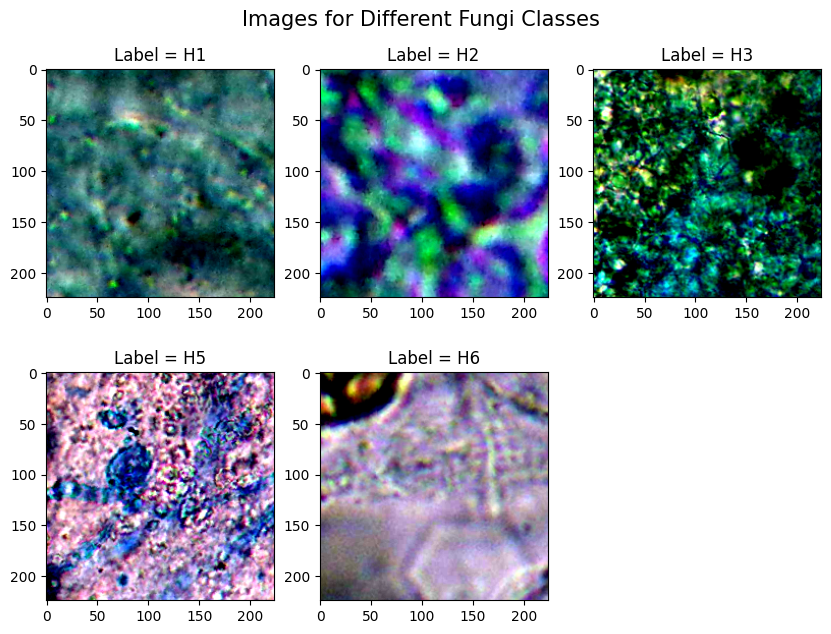

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
fig.delaxes(axes[1][2])
# To remove last empty subplot
axes = axes.flatten()
for i, ax in enumerate(axes):
    np_array = images[indices[i]].numpy().transpose(1,2,0)
    np_array[np_array < 0] = 0
    np_array[np_array > 1] = 1
    # After transformation, values may not lie between 0 and 1, so we clip the values 
    # which don't lie in said range
    ax.imshow(np_array)
    ax.set_title(f'Label = {idx_to_class[labels[indices[i]].item()]}')
    if (i==4):
        break
fig.suptitle('Images for Different Fungi Classes', fontsize = 15, y = 0.82)
# There was a lot of white space between plots and figures, so we adjusted it using y value.
plt.subplots_adjust(wspace=0.2,hspace=-0.35)
# There was a lot of white space between plots, so we adjusted it using hspace 

### Training a model

In [24]:
def training(model, model_name, loss_fn, optimizer, scheduler, num_epochs = 25, patience = 5):
    min_loss = np.inf
    count = 0
    history = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0 
        
        valid_loss = 0.0
        valid_acc = 0.0
        for _, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            y_preds = model(inputs)
            loss = loss_fn(y_preds, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(inputs)
            correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
            train_acc += correct_counts
        
        with torch.no_grad():
            model.eval()
            for _, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                y_preds = model(inputs)
                loss = loss_fn(y_preds, labels)
                valid_loss += loss.item()*len(inputs)
                correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
                valid_acc += correct_counts
        
        train_loss = train_loss/train_size
        train_acc = train_acc/train_size
        
        valid_loss = valid_loss/valid_size
        valid_acc = valid_acc/valid_size
        
        history.append([train_acc, train_loss, valid_acc, valid_loss]) 
        print(f'Epoch No. {epoch+1}')
        print(f'Training Accuracy = {train_acc:.4f}, Loss = {train_loss:.4f}')
        print(f'Validation Accuracy = {valid_acc:.4f}, Loss = {valid_loss:.4f}')
        torch.save(model.state_dict(), model_name + 'last_epoch.pt')
        
        scheduler.step(valid_loss)
        
        if (valid_loss < min_loss):
            count = 0 
            min_loss = valid_loss 
            torch.save(model.state_dict(), model_name + 'best_model.pt')
        
        else:
            count += 1
            if (count >= patience):
                print(f'Early stop at Epoch Number. {epoch + 1}')
                break 
        
    return model, history

### Accuracy for test data

In [37]:
test_dataset_path = './data/test'
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform=img_transforms['test'])
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_size = len(test_dataset)

In [44]:
def get_accuracy(trained_model, loss_fn):
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        trained_model.eval()
        for _, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_preds = trained_model(inputs)
            loss = loss_fn(y_preds, labels)
            test_loss += loss.item()*len(inputs)
            correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
            test_acc += correct_counts
    test_loss = test_loss/test_size
    test_acc = test_acc/test_size
    print(f'Loss for test set = {test_loss:.4f}')
    print(f'Accuracy for test set = {test_acc:.4f}')
    return test_loss, test_acc

### Making Prediction

In [66]:
def predict(model, x):
    pred = model(x.unsqueeze(0).to(device))
    return torch.argmax(pred, dim=1).item()

### EfficientNet_v2_m model

In [26]:
efficient_net_model = models.efficientnet_v2_m(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 142MB/s] 


In [27]:
efficient_net_model 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [28]:
efficient_net_model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

We don't want to train all parameters.

In [29]:
for params in efficient_net_model.parameters():
    params.requires_grad = False 

In [30]:
efficient_net_model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=512)
efficient_net_model.classifier.append(torch.nn.Linear(in_features=512, out_features=64))
efficient_net_model.classifier.append(torch.nn.Linear(in_features=64, out_features=5))

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=512, bias=True)
  (2): Linear(in_features=512, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=64, bias=True)
)

In [33]:
efficient_net_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

Changing last layer of Efficient net

In [34]:
summary(efficient_net_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14         [-1, 24, 1

In [36]:
learning_rate = 0.001
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_net_model.parameters(), lr = learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
trained_model_efficient_net, history = training(efficient_net_model, 'efficient_net_', loss_fn, optimizer, scheduler, num_epochs=50, patience=10)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch No. 1
Training Accuracy = 0.5469, Loss = 1.1736
Validation Accuracy = 0.6408, Loss = 0.9581


  5%|▌         | 1/20 [01:34<30:00, 94.79s/it]

Epoch No. 2
Training Accuracy = 0.5849, Loss = 1.0201
Validation Accuracy = 0.6320, Loss = 0.9182


 10%|█         | 2/20 [03:08<28:13, 94.08s/it]

Epoch No. 3
Training Accuracy = 0.5946, Loss = 1.0215
Validation Accuracy = 0.6503, Loss = 0.8629


 15%|█▌        | 3/20 [04:42<26:42, 94.26s/it]

Epoch No. 4
Training Accuracy = 0.5961, Loss = 0.9947
Validation Accuracy = 0.6606, Loss = 0.8865


 20%|██        | 4/20 [06:16<25:03, 93.97s/it]

Epoch No. 5
Training Accuracy = 0.6048, Loss = 0.9849
Validation Accuracy = 0.6620, Loss = 0.9141


 25%|██▌       | 5/20 [07:49<23:24, 93.64s/it]

Epoch No. 6
Training Accuracy = 0.6055, Loss = 0.9883
Validation Accuracy = 0.6708, Loss = 0.8489


 30%|███       | 6/20 [09:23<21:54, 93.92s/it]

Epoch No. 7
Training Accuracy = 0.6188, Loss = 0.9524
Validation Accuracy = 0.6789, Loss = 0.9112


 35%|███▌      | 7/20 [10:55<20:11, 93.19s/it]

Epoch No. 8
Training Accuracy = 0.6100, Loss = 0.9766
Validation Accuracy = 0.6569, Loss = 0.8775


 40%|████      | 8/20 [12:29<18:41, 93.49s/it]

Epoch No. 9
Training Accuracy = 0.6150, Loss = 0.9535
Validation Accuracy = 0.6635, Loss = 0.8993


 40%|████      | 8/20 [14:01<21:02, 105.19s/it]

Early stop at Epoch Number. 9


In [45]:
loss, acc = get_accuracy(efficient_net_model, loss_fn)

Loss for test set = 8.0242
Accuracy for test set = 0.6667


In [ ]:
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
images, labels = next(iter(test_data_loader))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    np_array = images[i].numpy().transpose(1,2,0)
    ax.imshow(np_array)
    original_label = idx_to_class[labels[i].item()]
    pred_label = idx_to_class[predict(trained_model_efficient_net, images[i])]
    ax.set_title(f'True = {original_label}, Prediction = {pred_label}')
fig.suptitle('Predictions', fontsize = 20, y = 0.95)

plt.subplots_adjust(wspace=0.2,hspace= 0.3)

### Resnet152 Model

In [46]:
resnet152_model = models.resnet152(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 147MB/s]  


In [47]:
resnet152_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
resnet152_model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [50]:
for param in resnet152_model.parameters():
    param.requires_grad = False 

In [51]:
resnet152_model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, out_features=512),
    torch.nn.Linear(in_features=512, out_features=64),
    torch.nn.Linear(in_features=64, out_features=5)
)

In [52]:
resnet152_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
summary(resnet152_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [54]:
learning_rate = 0.001
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet152_model.parameters(), lr = learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
trained_model_resnet152, history = training(resnet152_model, 'resnet152_', loss_fn, optimizer, scheduler, num_epochs=50, patience=10)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch No. 1
Training Accuracy = 0.6017, Loss = 0.9689
Validation Accuracy = 0.6481, Loss = 0.8653


  5%|▌         | 1/20 [01:20<25:28, 80.46s/it]

Epoch No. 2
Training Accuracy = 0.6543, Loss = 0.8495
Validation Accuracy = 0.6518, Loss = 0.8587


 10%|█         | 2/20 [02:41<24:15, 80.83s/it]

Epoch No. 3
Training Accuracy = 0.6744, Loss = 0.8091
Validation Accuracy = 0.6738, Loss = 0.7988


 15%|█▌        | 3/20 [04:01<22:51, 80.65s/it]

Epoch No. 4
Training Accuracy = 0.6833, Loss = 0.7775
Validation Accuracy = 0.6738, Loss = 0.8257


 20%|██        | 4/20 [05:21<21:23, 80.25s/it]

Epoch No. 5
Training Accuracy = 0.6865, Loss = 0.7826
Validation Accuracy = 0.6796, Loss = 0.8119


 25%|██▌       | 5/20 [06:41<20:00, 80.04s/it]

Epoch No. 6
Training Accuracy = 0.6871, Loss = 0.7652
Validation Accuracy = 0.6811, Loss = 0.8096


 30%|███       | 6/20 [08:00<18:38, 79.91s/it]

Epoch No. 7
Training Accuracy = 0.7028, Loss = 0.7464
Validation Accuracy = 0.6760, Loss = 0.8035


 30%|███       | 6/20 [09:20<21:47, 93.42s/it]

Early stop at Epoch Number. 7


In [74]:
loss, acc = get_accuracy(resnet152_model, loss_fn)

Loss for test set = 0.7716
Accuracy for test set = 0.7010


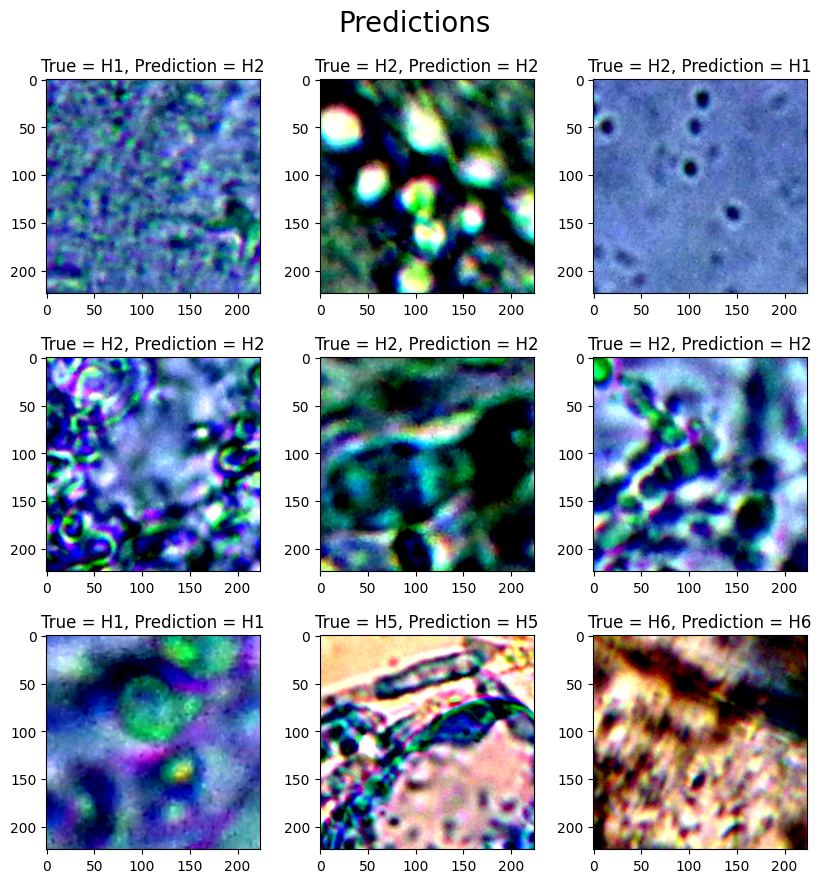

In [88]:
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
images, labels = next(iter(test_data_loader))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    np_array = images[i].numpy().transpose(1,2,0)
    ax.imshow(np_array)
    original_label = idx_to_class[labels[i].item()]
    pred_label = idx_to_class[predict(trained_model_resnet152, images[i])]
    ax.set_title(f'True = {original_label}, Prediction = {pred_label}')
fig.suptitle('Predictions', fontsize = 20, y = 0.95)

plt.subplots_adjust(wspace=0.2,hspace= 0.3)
